# Task 1 — Financial Analysis (Cleaning, Returns, Stationarity, Risk Metrics)

This notebook is primarily a **reporting notebook**: the official deliverables are generated by scripts and saved to disk.

## Rubric-fast deliverables covered here
1. Scaling/normalization evidence (a saved scaled dataset)
2. Three visualizations saved as files
3. Returns + stationarity (ADF) + risk metrics loaded from artifacts

**Artifacts expected (after running scripts):**
- `data/task1/processed/prices.parquet`
- `data/task1/processed/returns.parquet`
- `data/task1/processed/scaled_task1_prices.parquet` ✅ scaling evidence
- `data/task1/processed/task1_adf_results.csv`
- `data/task1/processed/task1_risk_metrics.csv`
- `outputs/task1/viz/task1_prices_timeseries.png` ✅ plot 1
- `outputs/task1/viz/task1_daily_pct_change.png` ✅ plot 2
- `outputs/task1/viz/task1_rolling_mean_std.png` ✅ plot 3


In [1]:
import os
import sys
from pathlib import Path
import importlib

import pandas as pd
import matplotlib.pyplot as plt


def _find_repo_root(start: Path) -> Path:
    """Walk upward until we find a folder containing both `src/` and `outputs/` or `data/`."""
    start = start.resolve()
    for candidate in [start, *start.parents]:
        if (candidate / "src").is_dir() and ((candidate / "outputs").exists() or (candidate / "data").exists()):
            return candidate
    return start


REPO_ROOT = _find_repo_root(Path.cwd())

# Make imports and relative paths work consistently from notebooks/
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
os.chdir(REPO_ROOT)

from src import config as config
config = importlib.reload(config)

print("Repo root:", REPO_ROOT)
print("Notebook working directory (after chdir):", os.getcwd())
print("config file:", getattr(config, "__file__", None))
print("PRICES_PATH:", config.PRICES_PATH)
print("RETURNS_PATH:", config.RETURNS_PATH)
print("TASK1_SCALED_PRICES_PATH:", getattr(config, "TASK1_SCALED_PRICES_PATH", None))
print("TASK1_VIZ_DIR:", getattr(config, "TASK1_VIZ_DIR", None))


Repo root: D:\Python\Week 9\portfolio-optimization
Notebook working directory (after chdir): D:\Python\Week 9\portfolio-optimization
config file: D:\Python\Week 9\portfolio-optimization\src\config.py
PRICES_PATH: data/task1/processed/prices.parquet
RETURNS_PATH: data/task1/processed/returns.parquet
TASK1_SCALED_PRICES_PATH: data/task1/processed/scaled_task1_prices.parquet
TASK1_VIZ_DIR: outputs/task1/viz


## 1) Load Task 1 datasets (prices + returns)

These should already exist if you ran your Task 1 pipeline scripts.

In [2]:
prices = pd.read_parquet(config.PRICES_PATH)
returns = pd.read_parquet(config.RETURNS_PATH)

display(prices.head())
display(returns.head())
print('prices shape:', prices.shape)
print('returns shape:', returns.shape)

,date,asset,open,high,low,close,adj_close,volume
0,2015-01-02,BND,82.430000,82.690002,82.419998,82.650002,60.386005,2218800
1,2015-01-05,BND,82.739998,82.919998,82.699997,82.889999,60.561321,5820100
2,2015-01-06,BND,83.029999,83.379997,83.029999,83.129997,60.736645,3887600
3,2015-01-07,BND,83.139999,83.279999,83.050003,83.180000,60.773186,2433400
4,2015-01-08,BND,83.110001,83.110001,82.970001,83.050003,60.678204,1873400


,date,asset,open,high,low,close,adj_close,volume,return
0,2015-01-02,BND,82.430000,82.690002,82.419998,82.650002,60.386005,2218800,NaN
1,2015-01-05,BND,82.739998,82.919998,82.699997,82.889999,60.561321,5820100,0.002903
2,2015-01-06,BND,83.029999,83.379997,83.029999,83.129997,60.736645,3887600,0.002895
3,2015-01-07,BND,83.139999,83.279999,83.050003,83.180000,60.773186,2433400,0.000602
4,2015-01-08,BND,83.110001,83.110001,82.970001,83.050003,60.678204,1873400,-0.001563


prices shape: (8325, 8)
returns shape: (8325, 9)


## 2) Scaling / normalization evidence

Rubric requirement: demonstrate scaling/normalization. Preferred evidence: a saved scaled dataset.

This notebook will **auto-generate** a scaled dataset if it does not exist yet (see the next cell), and save it to `config.TASK1_SCALED_PRICES_PATH`.


In [3]:
# Scaling/normalization evidence
# If a scaled dataset exists, load it; otherwise generate it from `prices`.

scaled_path = getattr(config, 'TASK1_SCALED_PRICES_PATH', None)
if scaled_path is None:
    # fallback to the repo convention used by this notebook
    scaled_path = str(REPO_ROOT / 'data' / 'task1' / 'processed' / 'scaled_task1_prices.parquet')

if os.path.exists(scaled_path):
    scaled_prices = pd.read_parquet(scaled_path)
    print('Loaded scaled dataset:', scaled_path)
else:
    if 'prices' not in globals():
        prices = pd.read_parquet(config.PRICES_PATH)

    price_col = getattr(config, 'PRICE_COL', 'adj_close')

    def _minmax(s: pd.Series) -> pd.Series:
        s = s.astype(float)
        denom = (s.max() - s.min())
        if denom == 0:
            return s * 0.0
        return (s - s.min()) / denom

    scaled_prices = prices.copy()
    scaled_prices[f'{price_col}_scaled'] = scaled_prices.groupby('asset')[price_col].transform(_minmax)

    os.makedirs(os.path.dirname(scaled_path), exist_ok=True)
    scaled_prices.to_parquet(scaled_path, index=False)
    print('Created scaled dataset:', scaled_path)

display(scaled_prices.head())
print('scaled_prices shape:', scaled_prices.shape)
print('scaled columns:', list(scaled_prices.columns))


Loaded scaled dataset: data/task1/processed/scaled_task1_prices.parquet


,date,asset,open,high,low,close,adj_close,volume,adj_close_scaled
0,2015-01-02,BND,82.430000,82.690002,82.419998,82.650002,60.385944,2218800,0.041987
1,2015-01-05,BND,82.739998,82.919998,82.699997,82.889999,60.561317,5820100,0.052701
2,2015-01-06,BND,83.029999,83.379997,83.029999,83.129997,60.736660,3887600,0.063412
3,2015-01-07,BND,83.139999,83.279999,83.050003,83.180000,60.773186,2433400,0.065643
4,2015-01-08,BND,83.110001,83.110001,82.970001,83.050003,60.678226,1873400,0.059842


scaled_prices shape: (8325, 9)
scaled columns: ['date', 'asset', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'adj_close_scaled']


## 3) Visualizations (must exist as files)

This section verifies the three plot files are present.

If any are missing, rerun:
```bash
python scripts/02_task1_scale_and_viz.py
```

In [4]:
viz_dir = getattr(config, 'TASK1_VIZ_DIR', 'outputs/task1/viz')
os.makedirs(viz_dir, exist_ok=True)

expected = [
    os.path.join(viz_dir, 'task1_prices_timeseries.png'),
    os.path.join(viz_dir, 'task1_daily_pct_change.png'),
    os.path.join(viz_dir, 'task1_rolling_mean_std.png'),
]

missing = [p for p in expected if not os.path.exists(p)]
print('Expected plots:')
for p in expected:
    print(' -', p, 'OK' if os.path.exists(p) else 'MISSING')

if missing:
    print('\nSome plots are missing; generating them now...')

    if 'prices' not in globals():
        prices = pd.read_parquet(config.PRICES_PATH)
    if 'returns' not in globals():
        returns = pd.read_parquet(config.RETURNS_PATH)

    prices['date'] = pd.to_datetime(prices['date'])
    returns['date'] = pd.to_datetime(returns['date'])

    price_col = getattr(config, 'PRICE_COL', 'adj_close')

    # 1) Prices time series
    plt.figure(figsize=(12, 5))
    for asset, g in prices.sort_values('date').groupby('asset'):
        plt.plot(g['date'], g[price_col], label=asset, linewidth=1.5)
    plt.title(f'Prices over time ({price_col})')
    plt.xlabel('Date')
    plt.ylabel(price_col)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(expected[0], dpi=150)
    plt.close()

    # 2) Daily percent change
    tmp = None
    if 'return' in returns.columns:
        tmp = returns.copy()
        tmp['pct_change'] = tmp['return'].astype(float) * 100.0
    else:
        tmp = prices.sort_values('date').copy()
        tmp['pct_change'] = tmp.groupby('asset')[price_col].pct_change() * 100.0

    plt.figure(figsize=(12, 5))
    for asset, g in tmp.groupby('asset'):
        plt.plot(g['date'], g['pct_change'], label=asset, linewidth=1.0)
    plt.title('Daily % change')
    plt.xlabel('Date')
    plt.ylabel('%')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(expected[1], dpi=150)
    plt.close()

    # 3) Rolling mean/std (20D) of daily % change
    window = 20
    tmp2 = tmp.sort_values('date').copy()
    tmp2['roll_mean'] = tmp2.groupby('asset')['pct_change'].transform(lambda s: s.rolling(window).mean())
    tmp2['roll_std'] = tmp2.groupby('asset')['pct_change'].transform(lambda s: s.rolling(window).std())

    fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
    for asset, g in tmp2.groupby('asset'):
        axes[0].plot(g['date'], g['roll_mean'], label=asset, linewidth=1.2)
        axes[1].plot(g['date'], g['roll_std'], label=asset, linewidth=1.2)

    axes[0].set_title(f'Rolling mean of daily % change ({window}D)')
    axes[1].set_title(f'Rolling std of daily % change ({window}D)')
    for ax in axes:
        ax.grid(True, alpha=0.3)
        ax.legend()

    axes[1].set_xlabel('Date')
    fig.tight_layout()
    fig.savefig(expected[2], dpi=150)
    plt.close(fig)

    missing = [p for p in expected if not os.path.exists(p)]

if missing:
    raise FileNotFoundError(
        'Missing required Task 1 plot files:\n' + '\n'.join(missing)
    )

print('\nAll required plot files exist.')


Expected plots:
 - outputs/task1/viz\task1_prices_timeseries.png OK
 - outputs/task1/viz\task1_daily_pct_change.png OK
 - outputs/task1/viz\task1_rolling_mean_std.png OK

All required plot files exist.


### Display the saved plot images (optional)

If your Jupyter environment supports it, we can display them inline.

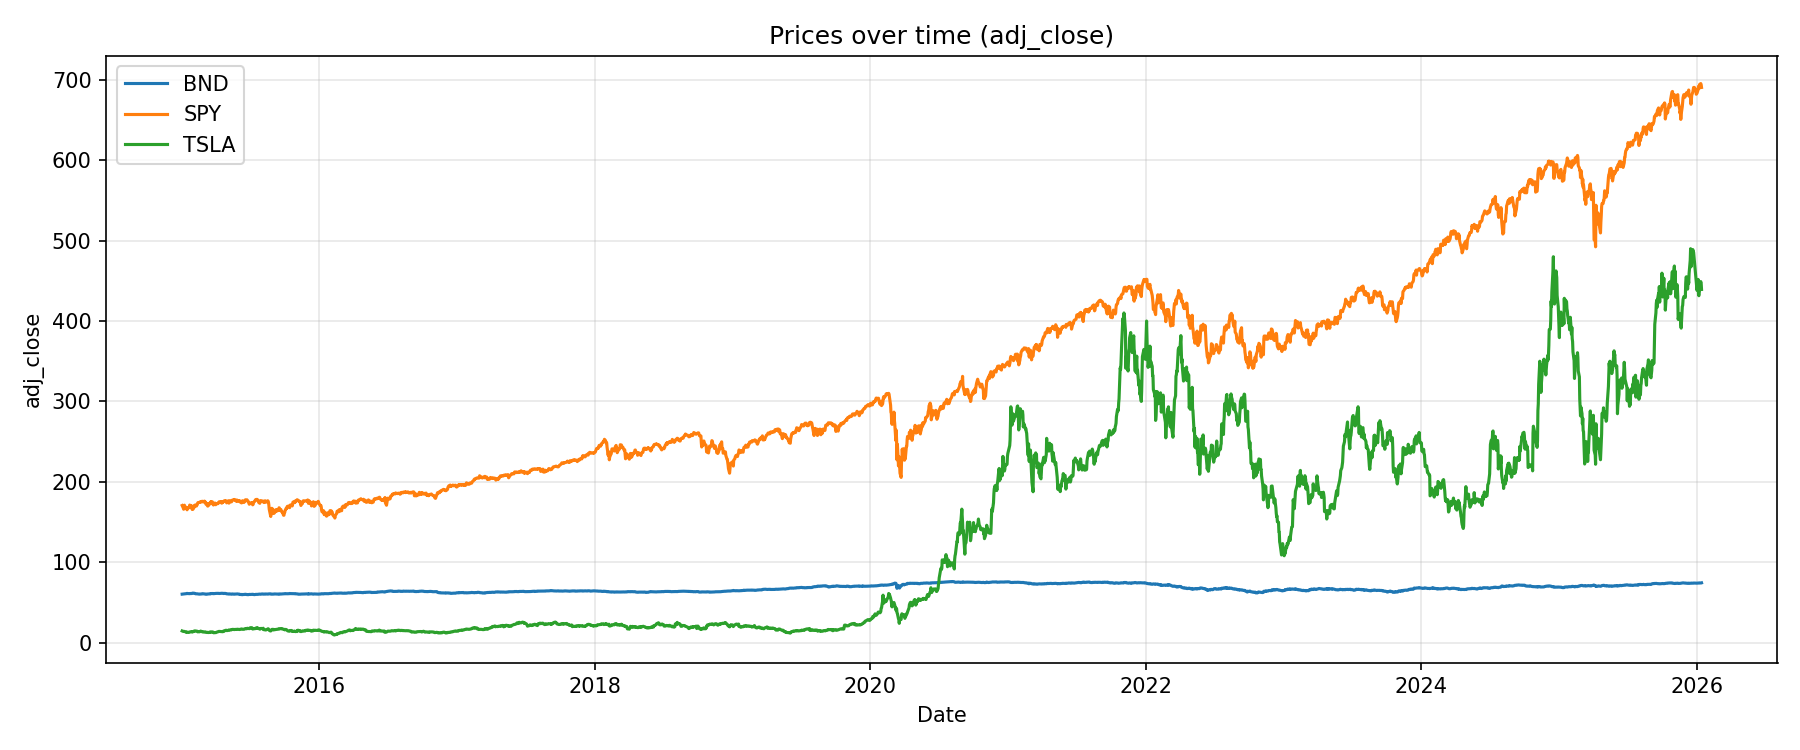

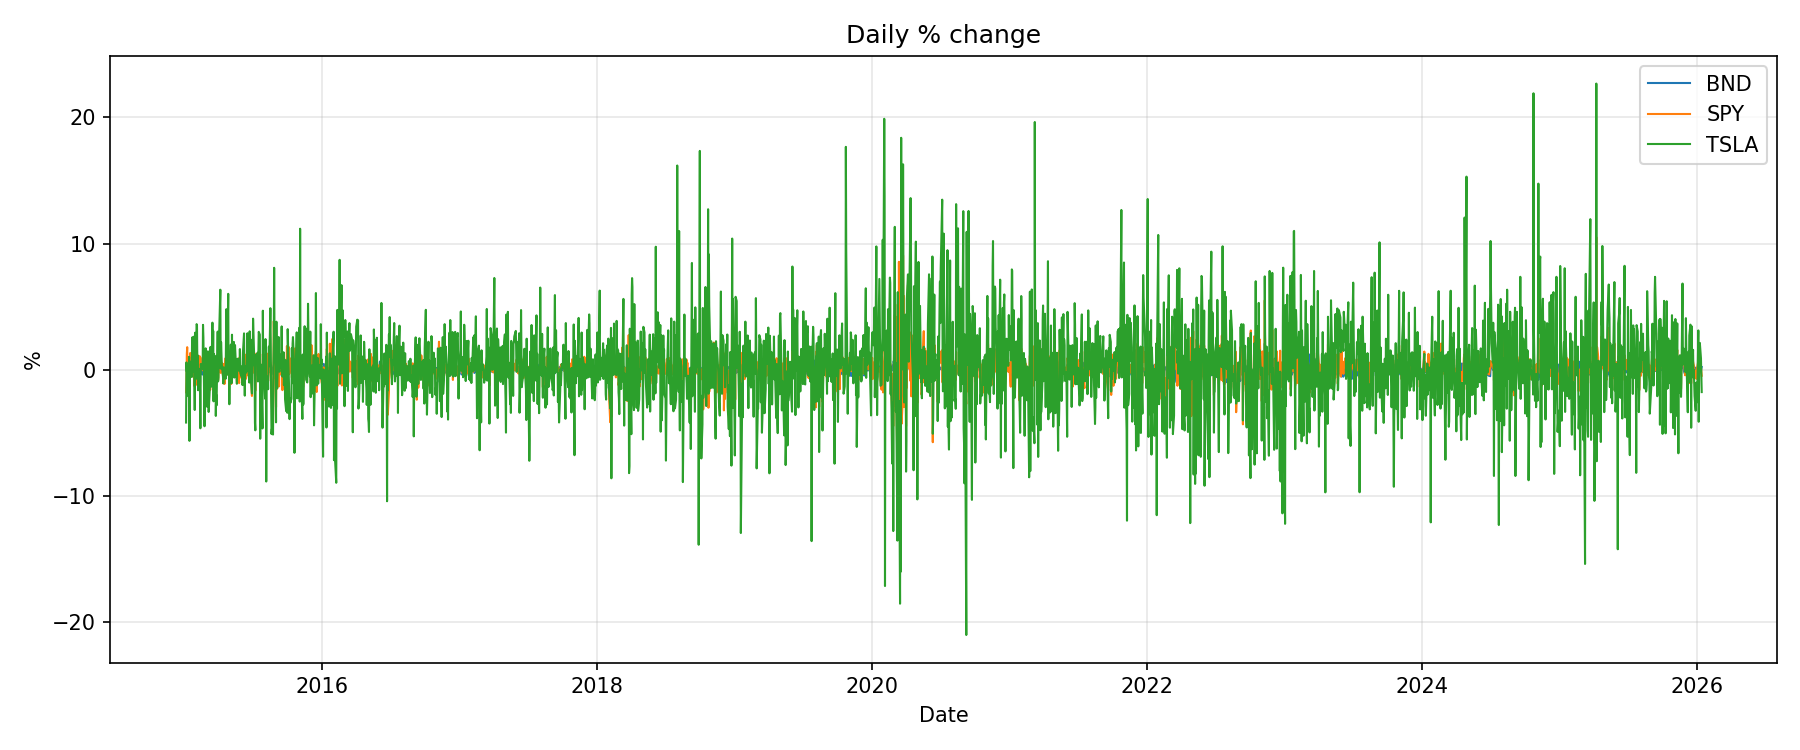

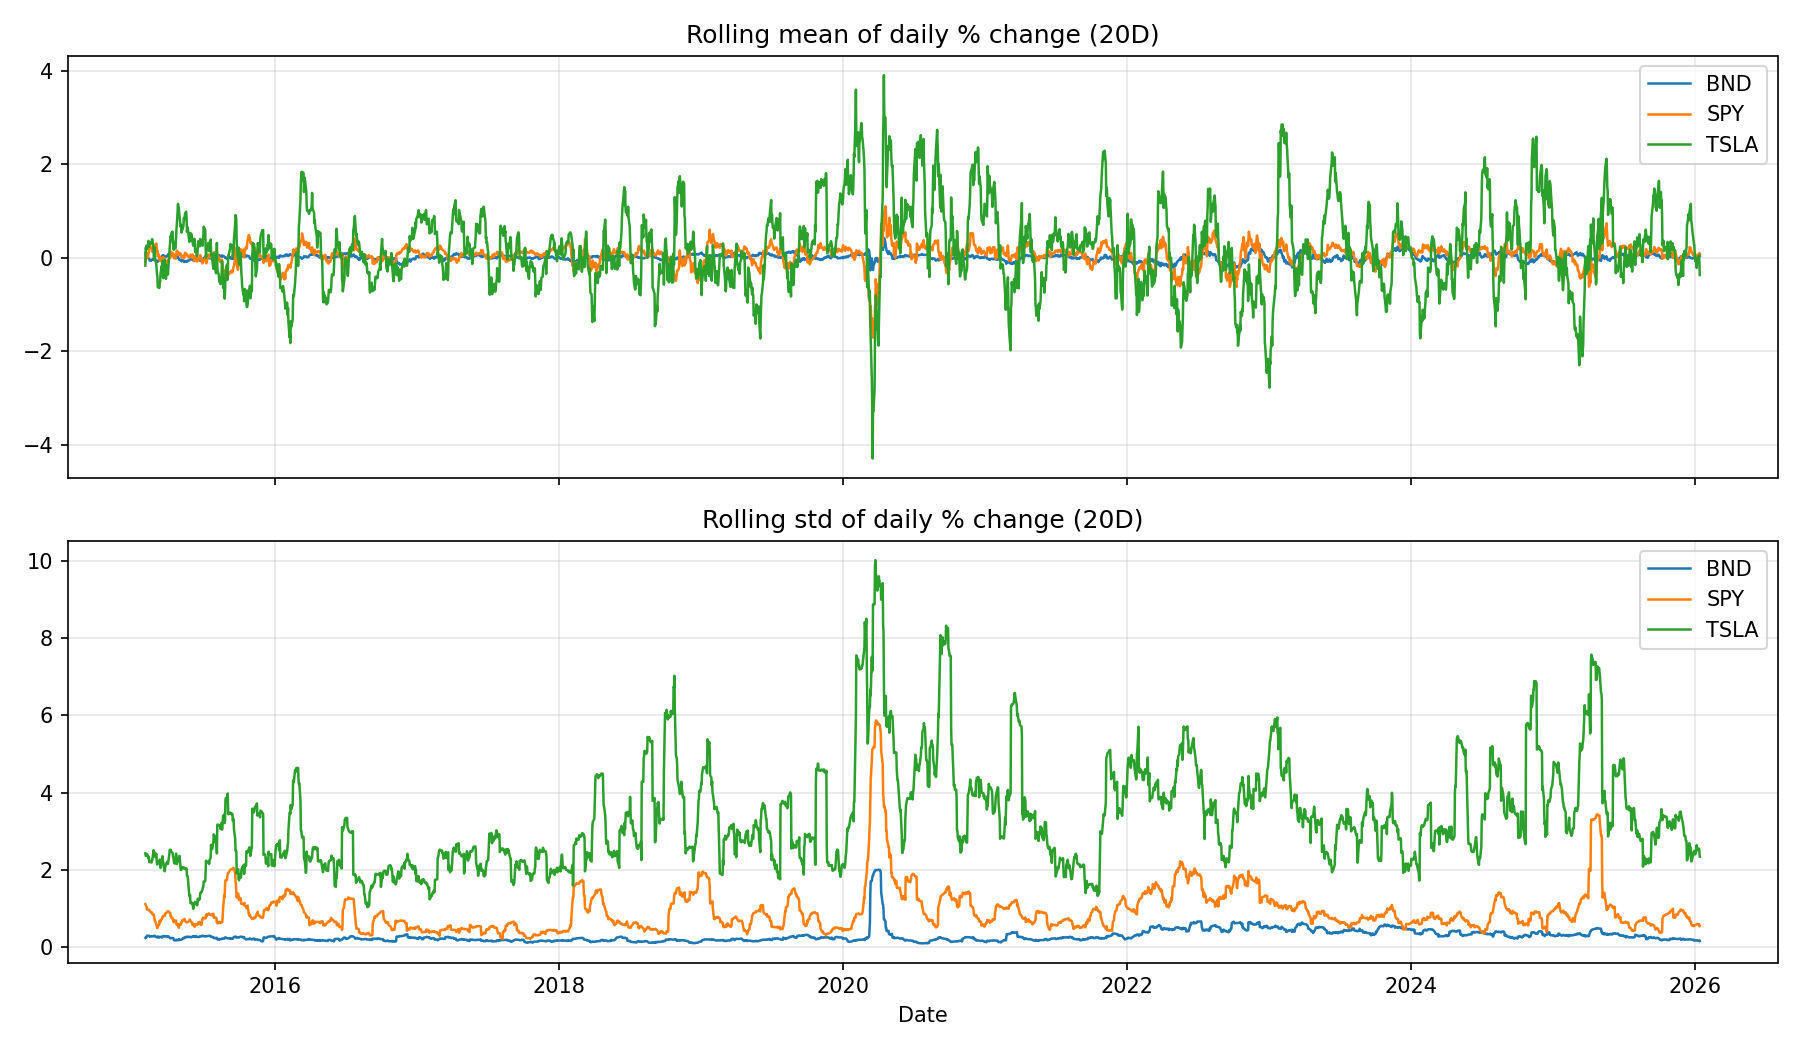

In [5]:
from IPython.display import Image, display

for p in expected:
    display(Image(filename=p))

## 4) Stationarity evidence (ADF results)

ADF outputs should be saved to CSV by your Task 1 scripts.

In [6]:
adf_path = config.TASK1_ADF_PATH
if not os.path.exists(adf_path):
    raise FileNotFoundError(f'Missing ADF results: {adf_path}. Run Task 1 scripts.')

adf = pd.read_csv(adf_path)
display(adf)
print('ADF file:', adf_path)

,asset,series,test_stat,p_value,used_lag,n_obs,is_stationary_5pct,crit_1pct,crit_5pct,crit_10pct
0,BND,adj_close,-1.051373,7.340693e-01,13,2761,False,-3.432721,-2.862587,-2.567328
1,BND,return,-10.433726,1.586172e-18,23,2750,True,-3.432730,-2.862592,-2.567330
2,SPY,adj_close,1.170880,9.957784e-01,9,2765,False,-3.432717,-2.862586,-2.567327
3,SPY,return,-17.228849,6.211425e-30,8,2765,True,-3.432717,-2.862586,-2.567327
4,TSLA,adj_close,-0.780157,8.248814e-01,28,2746,False,-3.432734,-2.862593,-2.567331
5,TSLA,return,-53.019619,0.000000e+00,0,2773,True,-3.432710,-2.862583,-2.567325


ADF file: data/task1/processed/task1_adf_results.csv


## 5) Risk metrics evidence

Risk metrics (e.g., annualized return/volatility, Sharpe, VaR) should be saved by scripts.

In [7]:
risk_path = config.TASK1_RISK_PATH
if not os.path.exists(risk_path):
    raise FileNotFoundError(f'Missing risk metrics: {risk_path}. Run Task 1 scripts.')

risk = pd.read_csv(risk_path)
display(risk)
print('Risk metrics file:', risk_path)

,asset,var_level,VaR,ann_vol,sharpe_rf_annual,sharpe
0,BND,0.95,0.004796,0.053567,0.02,0.008096
1,SPY,0.95,0.016719,0.177676,0.02,0.691427
2,TSLA,0.95,0.052529,0.576923,0.02,0.788518


Risk metrics file: data/task1/processed/task1_risk_metrics.csv


## 6) Quick interpretation (short)

- Prices are typically non-stationary; returns/log returns tend to be closer to stationary.
- Scaling provides comparable magnitudes across assets for visualization and certain models.
- Risk metrics summarize reward vs risk and tail behavior for each asset.